# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Esercitazione numerica 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D

seed=24
np.random.seed(seed) # fisso un seed per poter riprodurre i risultati
tf.random.set_seed(seed)

Using TensorFlow backend.


### Esercizio 12.1

L'obiettivo dell'esercizio è utilizzare un *deep neural network model* (DNN) per riconoscere e distinguere le cifre scritte a mano del dataset MNIST.

Ho dunque eseguito il training della rete neurale usando 3 diversi optimizer: **SGD, Adam, RMSprop**; mantenendo inalterati gli altri parametri ed osservando *loss* e *accuracy* del training set del validation set.
Il procedimento segue quello descritto nel jupyter notebook dell'esercitazione

**Step 1: Load and Process the Data**

In [2]:
from keras.datasets import mnist

# Input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# Output
num_classes = 10 # 10 digits

# The data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# Convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


**Step 2: Define the neural Net and its Architecture**

In [3]:
# Define the NN architecture
def create_DNN():
    # Instantiate model
    model = Sequential()
    # Add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # Add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # Apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # Soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


**Step 3: Choose the Optimizer and the Cost function**

In [4]:
def compile_model(optim):
    # Create the model
    model = create_DNN()
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


**Step 4: Train the model + Step 5: Evaluate the Model Performance on the Unseen Test Data**

2021-08-31 18:35:15.755608: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-31 18:35:15.756110: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Optimizer:  sgd
Test-loss: 0.16034437976926566
Test-accuracy: 0.9513000249862671


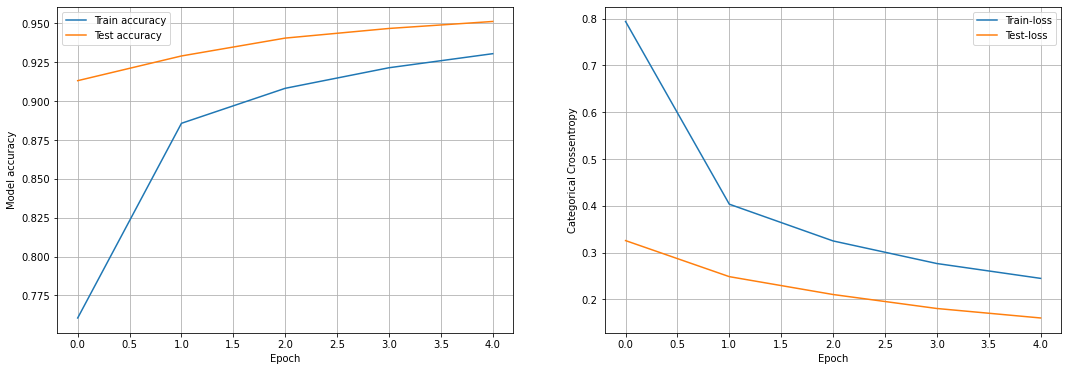

Optimizer:  Adam
Test-loss: 0.07596054689160482
Test-accuracy: 0.9796000123023987


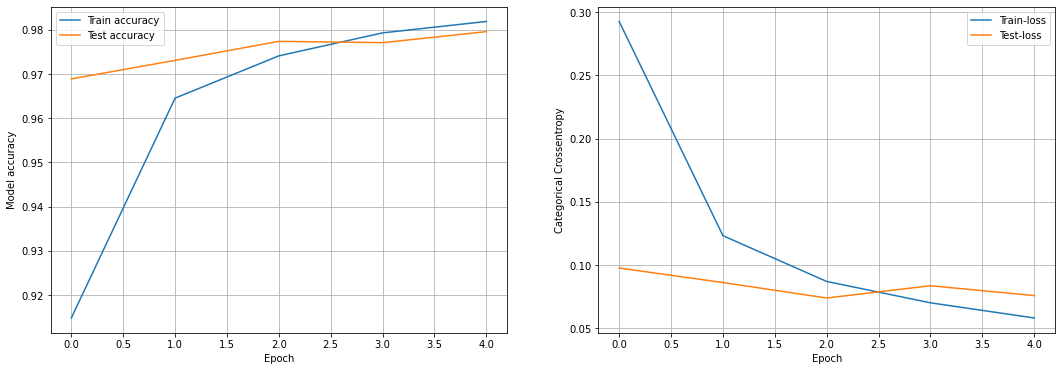

Optimizer:  RMSprop
Test-loss: 0.15552378324545862
Test-accuracy: 0.9749000072479248


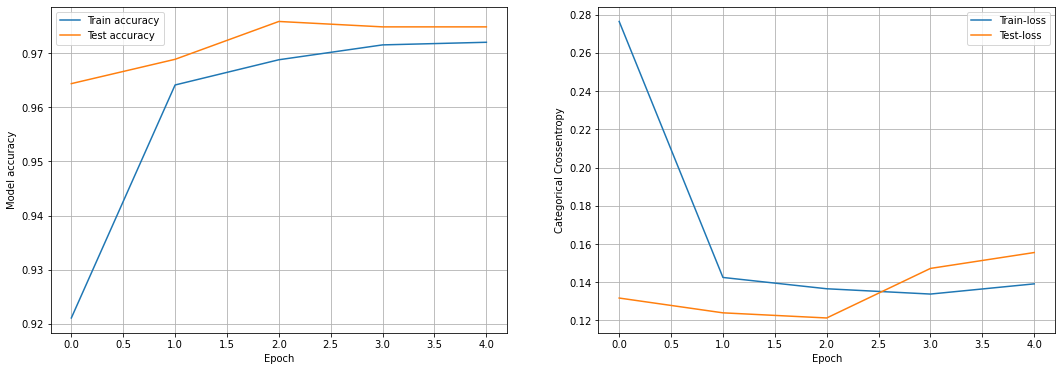

In [5]:
# Training parameters
batch_size = 32
epochs = 5

optims = ["sgd", "Adam", "RMSprop"]

index = 1

for optim in optims:
    
    # Create the deep neural net
    model_DNN = compile_model(optim)

    # Train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test))
    
    # Evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=0)

    # Print performance
    print('Optimizer: ', optim)
    print('Test-loss:', score[0])
    print('Test-accuracy:', score[1])
    
    # Plot train and validation acccuracy and loss 
    plt.figure(index, figsize = (18, 6))
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('Model accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
    plt.grid(True)
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Categorical Crossentropy')
    plt.xlabel('Epoch')
    plt.legend(['Train-loss', 'Test-loss'], loc='best')
    plt.grid(True)
    
    plt.show()
    
    index = index + 1

Tutte e tre le reti producono valori di accuracy superiori al $95\%$.

La rete neurale che utilizza `Adam` è quella che da' risultati migliori.
Nel loss-plot la curva di training sembra continuare a descrescere mentre la quella di test sembra abbastanza stabile; questo mi fa pensare che sia possibile che aumentando il tempo di training si incorra in un *overfitting*.

Il grafico di `RMSprop` mostra un periodo in cui l'accuracy nel test set inizia a calare per poi riprendere a salire; l'andamento corrisponde nel loss-plot.
E' probabile che aumentando il tempo di training la performance migliori.



### Esercizio 12.2

La richiesta è di migliorare l'architettura della nostra DNN utilizzando dei *convolutional layers* per tenere conto anche della correlazione spaziale tra i pixel, in modo da provare a migliorare l'accuratezza del modello.

Ho usato `Conv2d`, `MaxPooling2D`, `Dropout`, `Flatten`, `Dense` e `soft-max` layers per creare la rete richiesta.



In [6]:
# Reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [7]:
def create_CNN():
    # Instantiate model
    model = Sequential()
    
    # Add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    # Add MaxPooling layer                           
    model.add(MaxPooling2D(pool_size=2))
    # Add convolutional layer with 5 filters
    model.add(Conv2D(5, kernel_size=(5, 5), activation='relu'))
    # Add MaxPooling layer                              
    model.add(MaxPooling2D(pool_size=2))
    # Add Flatten layer
    model.add(Flatten())
    # Add FC layer (relu)
    model.add(Dense(120, activation='relu'))
    # Add FC layer (softmax)
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer = 'SGD',
                  metrics = ['acc'])
    
    return model

Eseguo il training della DCNN con gli stessi parametri usati nell'esercizio precedente

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 142s 2ms/step - loss: 0.5919 - acc: 0.8094 - val_loss: 0.1939 - val_acc: 0.9387
Epoch 2/5
60000/60000 [==============================] - 167s 3ms/step - loss: 0.1658 - acc: 0.9496 - val_loss: 0.1232 - val_acc: 0.9621
Epoch 3/5
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1214 - acc: 0.9626 - val_loss: 0.0945 - val_acc: 0.9700
Epoch 4/5
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1008 - acc: 0.9692 - val_loss: 0.0853 - val_acc: 0.9723
Epoch 5/5
10000/10000 [==============================] - 3s 341us/step

Test-loss: 0.0707986872411333
Test-accuracy: 0.9782999753952026


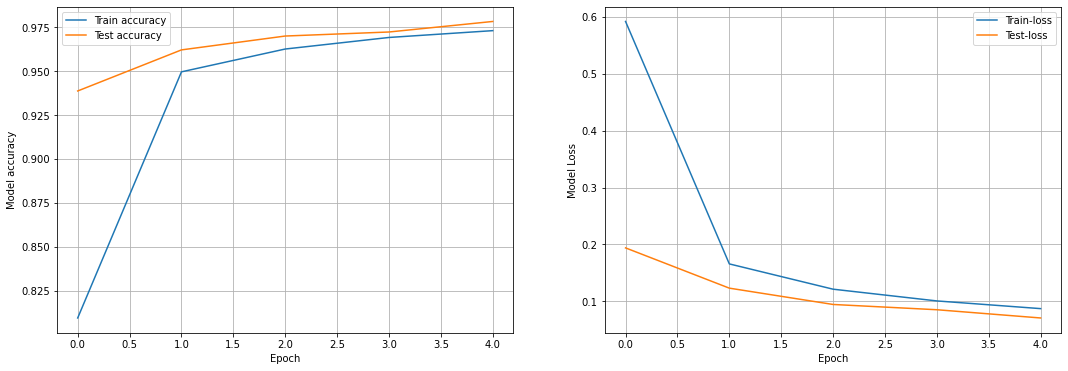

In [8]:
# Training parameters
batch_size = 32
epochs = 5

# Create the deep conv net
model_CNN=create_CNN()

# Train CNN
history = model_CNN.fit(X_train, Y_train, batch_size = batch_size,
                        epochs = epochs, verbose = 1, 
                        validation_data = (X_test, Y_test))

# Evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# Print performance
print()
print('Test-loss:', score[0])
print('Test-accuracy:', score[1])

# Plot train and validation accuracy and loss vs epochs
plt.figure(index, figsize = (18, 6))
# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
plt.grid(True)
# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Model Loss')
plt.xlabel('Epoch')
plt.legend(['Train-loss', 'Test-loss'], loc='best')
plt.grid(True)

plt.show()

Come vediamo è possibile ottenere una miglior accuracy con `sgd` cambiando l'architettura in una DCNN.

### Esercizio 12.3

Per quest'ultimo esercizio ho utilizzato `gimp` per produrre 10 immagini di cifre scritte "a mano" da me per poi importarle utilizzando il codice fornito e vedere se la DCNN da me creata è in grado di riconoscerle.

Errors:  2


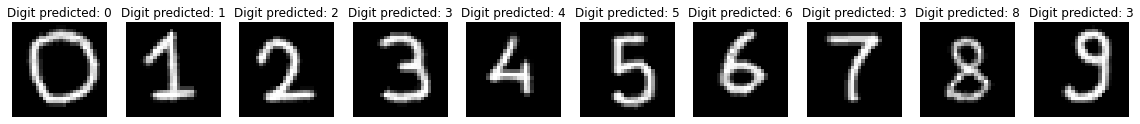

In [11]:
from PIL import Image
import os

errors = 0

plt.figure(figsize=(10*2,2))

for digit in range(10):
    digit_filename = "pictures/"+str(digit)+".png"
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    
    plt.subplot(1, 10, digit+1)
    
    plt.imshow(data, cmap='gray')
    
    data = data.reshape(1,xdim*ydim)

    if keras.backend.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        
    pred_0 = model_CNN.predict(data)
    
    if np.argmax(pred_0) != digit:
        errors = errors + 1
       
    plt.title("Digit predicted: {}".format(np.argmax(pred_0)))
    plt.axis('off')
    
print("Errors: ", errors)

Il mia rete neurale DNCC è riuscita a predirre correttamente 8 delle 10 cifre scritte da me.